In [23]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [24]:
def highlight(R, T, I, use_max=True):
    """
    Finds the location of maximum (or minimum) matching response, and 
    draws a rectangle on the image around this location.  The
    size of the rectangle is determined by template T.
    
    Returns an image with the drawn rectangle.  Also returns the loc and
    the value (maximum or minimum as the case may be).  The original image
    remains unchanged.
    """
    
    W, H = I.shape[0], I.shape[1]
    w, h = T.shape[0], T.shape[1]
    wr, hg = R.shape[0], R.shape[1]
        
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    loc1 = loc + np.array([h//2, w//2])               # Size of R is different from I 
    tl = loc1 - np.array([h//2, w//2])
    br = loc1 + np.array([h//2, w//2])
    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    cv.rectangle(I_, tuple(tl), tuple(br), c, 4)
    return I_, loc, val

In [25]:
def make_square(I):
    '''
    This function is used to construct a rectangular images to be used in generate gaussian pyramid

    The return value are the square shaped image and the max level can be used to generate gaussian pyramid
    '''
    h = I.shape[0]
    w = I.shape[1]
    
    n_levels = np.int(np.ceil(np.log(np.max([h,w]))/np.log(2)))
    new_h = np.power(2, n_levels)
    new_w = new_h
    
    if len(I.shape) == 3:
        tmp = np.zeros([new_h, new_w, I.shape[2]], dtype=I.dtype)
        tmp[:h,:w,:] = I
    else:
        tmp = np.zeros([new_h, new_w], dtype=I.dtype)
        tmp[:h,:w] = I

    return tmp, n_levels

In [26]:
def gen_gaussian_pyramid(I, levels):
    '''
    This function is used to generate gaussian pyramid
    The return value is a list contains different levels gaussian pyramid
    '''
    G = I.copy()
    gpI = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gpI.append(G)
    return gpI

In [27]:
def cover_match(orig_img, bbox):
    new_img = np.copy(orig_img)
    ept_list = np.array([0,0,0], dtype=np.float32)
    # for y in range(bbox[0], bbox[0] + bbox[2]):
    #     for x in range(bbox[1], bbox[1] + bbox[3]):
    #         new_img[x][y] = ept_list
    for y in range(0, bbox[0] + bbox[2]):
        for x in range(0, bbox[1] + bbox[3]):
            new_img[x][y] = ept_list

    return new_img

In [28]:
def challenge_sign_detection(orig_img, template, entity = 2):

    orig_img_copy = np.copy(orig_img)

    methods = ['cv.TM_CCOEFF', 
        'cv.TM_CCOEFF_NORMED', 
        'cv.TM_CCORR',
        'cv.TM_CCORR_NORMED', 
        'cv.TM_SQDIFF', 
        'cv.TM_SQDIFF_NORMED']

    squared_img, n_levels = make_square(orig_img_copy)
    
    
    gp_image = gen_gaussian_pyramid(squared_img, n_levels)

    useful_match = []

    for item in gp_image:
        if template.shape[0] <= item.shape[0] and template.shape[1] <= item.shape[1]:
            R_ = cv.matchTemplate(template, item, eval(methods[3]))
            useful_match.append(R_)

    # print(useful_match)
    R_val = np.empty([len(useful_match), 3])
    # print(R_val)
    highlighted_list = []
    for i in range(len(useful_match)):
        R_ = useful_match[i]
        T_ = template
        I_ = gp_image[i]

        H_, loc, val = highlight(R_, T_, I_)
        highlighted_list.append(H_)

        R_val[i, : ] = np.array([val, loc[0], loc[1]])

    # np.set_printoptions(suppress=True)
    # print(R_val)

    highest_match_pos = 0
    for index in range(0, len(R_val)):
        # print(R_val[index])
        if R_val[index][0] > R_val[highest_match_pos][0]:
            highest_match_pos = index
    # print(highest_match_pos)

    highest_match_box = R_val[highest_match_pos]
    # print(highest_match_box)

    highest_match_box[1] = highest_match_box[1] * np.power(2, highest_match_pos)
    highest_match_box[2] = highest_match_box[2] * np.power(2, highest_match_pos)
    # print(highest_match_box)



    match_box = np.array([highest_match_box[1], highest_match_box[2], template.shape[0], template.shape[1]], dtype=np.int32)
    # print(match_box)
    return match_box

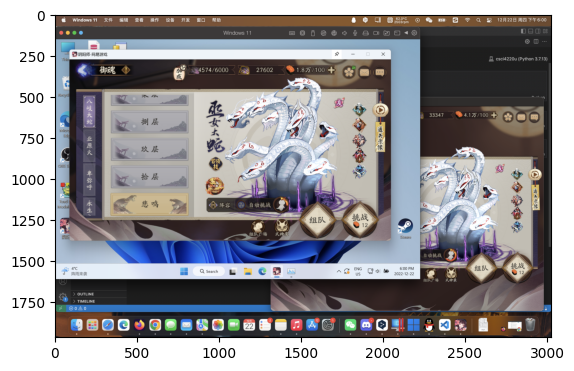

In [29]:
img_dual = cv.imread("pics/01-dual.png")
img_dual = cv.cvtColor(img_dual, cv.COLOR_BGR2RGB)
plt.imshow(img_dual)

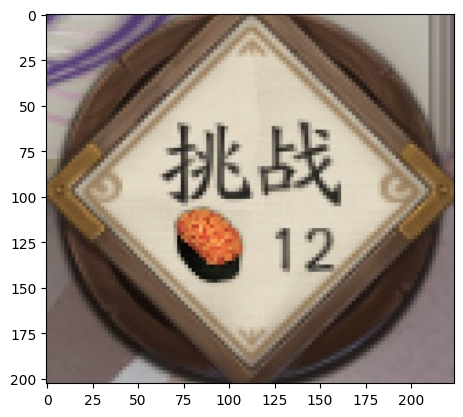

In [30]:
img_t = cv.imread("pics/01-T.jpg")
img_t = cv.cvtColor(img_t, cv.COLOR_BGR2RGB)
plt.imshow(img_t)

In [31]:
box = challenge_sign_detection(img_dual, img_t)
print(box)

/opt/anaconda3/envs/csci4220u/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


[1744 1154  203  224]


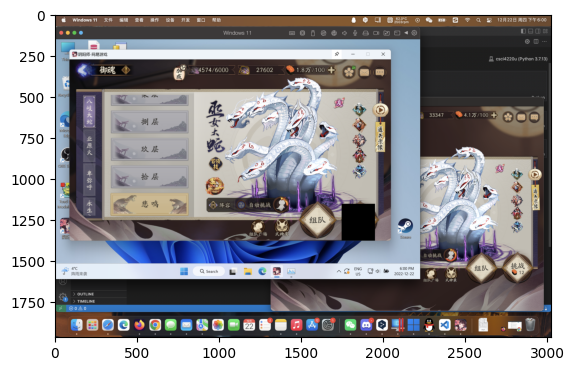

In [33]:
covered_match = cover_match(img_dual, box)
plt.imshow(covered_match)

In [58]:
boxx = challenge_sign_detection(covered_match, img_t)
print(boxx)

/opt/anaconda3/envs/csci4220u/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


[2700 1446  203  224]


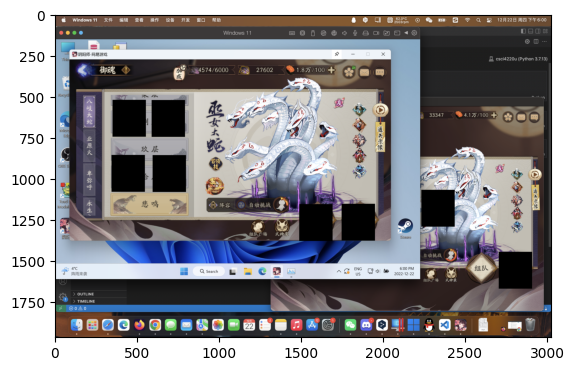

In [59]:
covered_match = cover_match(covered_match, boxx)
plt.imshow(covered_match)